## SSD Pre-train environment setup

In [ ]:
!unzip dataset_sample.zip

In [ ]:
!python partition_dataset.py -x -i ./dataset_sample -o ./Tensorflow/workspace/mask_detection/images -r 0.2

In [ ]:
label = """item {
    id: 1
    name: 'mask'
}

item {
    id: 2
    name: 'no-mask'
}
"""

file = open("sample.pbtxt", "w")
file.write("%s\n" % (label))
file.close()

In [ ]:
!mv sample.pbtxt ./Tensorflow/workspace/mask_detection/annotations
!ls ./Tensorflow/workspace/mask_detection/annotations
PATH_TO_IMAGES_FOLDER = "./Tensorflow/workspace/mask_detection/images"
PATH_TO_ANNOTATIONS_FOLDER = "./Tensorflow/workspace/mask_detection/annotations"
PATH_TO_PRETRAIN_FOLDER = "./Tensorflow/workspace/mask_detection/pre-trained-models"
!python generate_tfrecord.py -x $PATH_TO_IMAGES_FOLDER/train -l $PATH_TO_ANNOTATIONS_FOLDER/sample.pbtxt -o $PATH_TO_ANNOTATIONS_FOLDER/train.record
!python generate_tfrecord.py -x $PATH_TO_IMAGES_FOLDER/test -l $PATH_TO_ANNOTATIONS_FOLDER/sample.pbtxt -o $PATH_TO_ANNOTATIONS_FOLDER/test.record
## mobileNet SSD v2 pre-train model download
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz -O ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!tar -xvzf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!mv ssd_mobilenet_v2_320x320_coco17_tpu-8 $PATH_TO_PRETRAIN_FOLDER
!ls -R $PATH_TO_PRETRAIN_FOLDER

## modify pipeline.config file

- reference link 1 : https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
- reference link 2 : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md

In [ ]:
# PIPELINE_CONFIG_FILE = "./Tensorflow/workspace/mask_detection/pre-trained-models/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config"
# !sed -i.old 's/num_classes: 90/num_classes: 2/g' $PIPELINE_CONFIG_FILE
# !cat $PIPELINE_CONFIG_FILE | grep num_classes
# !sed -i 's/fine_tune_checkpoint_type: \"classification\"/fine_tune_checkpoint_type: \"detection\"/g' $PIPELINE_CONFIG_FILE
# 직접 pipeline.config file 수정할 수 있도록 함.

In [ ]:
!cp Tensorflow/models/research/object_detection/model_main_tf2.py Tensorflow/workspace/mask_detection/
!cp Tensorflow/models/research/object_detection/exporter_main_v2.py Tensorflow/workspace/mask_detection/

In [ ]:
%cd Tensorflow/workspace/mask_detection

In [ ]:
!mkdir models/my_ssd_mobilenet_v2
!cp pre-trained-models/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config ./models/my_ssd_mobilenet_v2/pipeline.config

In [82]:
## train, execution in terminal
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# !python model_main_tf2.py --model_dir=models/my_ssd_mobilenet_v2 --pipeline_config_path=models/my_ssd_mobilenet_v2/pipeline.config --worker_replicas=8 --num_clones=8 --ps_tasks=1

## Inference Test

- mask detection

In [89]:
## use tensorboard & port fowarding (use in terminal)
#python model_main_tf2.py --model_dir=models/my_ssd_mobilenet_v2 --pipeline_config_path=models/my_ssd_mobilenet_v2/pipeline.config --checkpoint_dir=models/my_ssd_mobilenet_v2

In [ ]:
#python exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/my_ssd_mobilenet_v2/pipeline.config --trained_checkpoint_dir models/my_ssd_mobilenet_v2 --output_directory exported-models/my_model

In [121]:
import os, sys, glob
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

images_path = os.path.join("./", "images/test")
saved_model = os.path.join("./", "exported-models/my_model/saved_model")
image_files = glob.glob(images_path + "/*.jpg")
detect_fn = tf.saved_model.load(saved_model)
PATH_TO_LABELS = os.path.join("./", "annotations/sample.pbtxt")
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

Running inference for ./images/test/1152x768_246964803156_jpg.rf.93e4584edd0a741914cf795c2087200d.jpg... Done
Running inference for ./images/test/1580166133-5b61094cac11561b0cbe09826e32a924_jpg.rf.fd801022283d5bce8079887db2ef980c.jpg... Done
Running inference for ./images/test/1140-travelers-at-hong-kong-airport_jpg.rf.4dac1dff15755783b3941a24fcdd12ae.jpg... Done
Running inference for ./images/test/1197315184_jpg_0_jpg.rf.448838b1a29be91ef9c08cc895837686.jpg... Done
Running inference for ./images/test/1580128422_jpg.rf.4496b0fe4afc307aa32966c8180bab49.jpg... Done


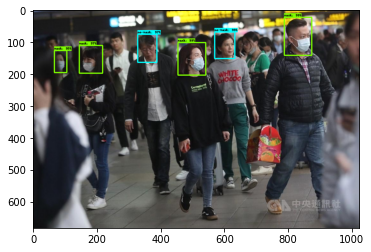

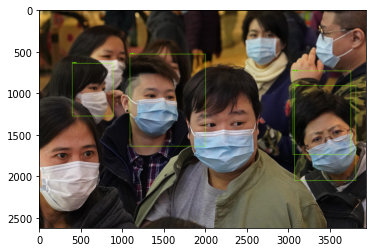

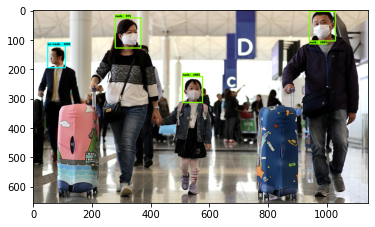

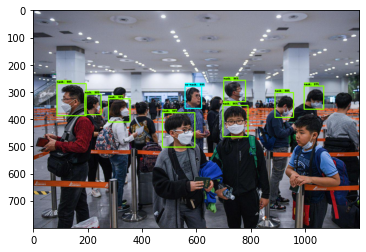

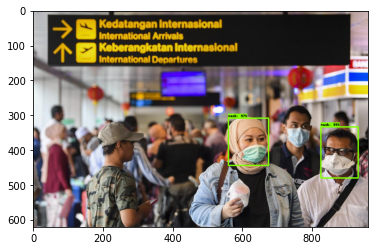

In [125]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

cnt=0
random.shuffle(image_files)

for image_path in image_files:
    if (cnt==5): break
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=500,
          min_score_thresh=.95,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    cnt+=1
plt.show()